### 1. Imports & Environment Setup and Data Organization (ISIC 2016)
This block imports all essential libraries for the project. We use `torch` for Deep Learning, `cv2` (OpenCV) and `PIL` for image processing, and `diffusers` for the Generative AI components. It also configures the execution device, prioritizing the GPU (CUDA) for faster training and generation.\
\
This script processes the raw ISIC 2016 dataset. Since the raw data comes as a flat list of images with a separate CSV file, this code reads the CSV labels and physically moves the images into structured `benign` and `malignant` folders, making them compatible with PyTorch's `ImageFolder` loader.

In [14]:
import os
import shutil
import pandas as pd
from tqdm import tqdm # Optional: for a nice progress bar
from skimage.exposure import match_histograms

# --- Configuration ---
# Define your paths relative to the project root
base_dir = os.getcwd()
raw_images_path = os.path.join(base_dir, "data", "raw", "ISIC_2016_Training_Data")
csv_path = os.path.join(base_dir, "data", "raw", "ISIC_2016_Training_GroundTruth.csv")
processed_path = os.path.join(base_dir, "data", "processed")

# --- Step 1: specific setup for ISIC CSV ---
# Load the CSV
df = pd.read_csv(csv_path)

# PRINT columns to verify (Check the output!)
print(f"Columns found: {df.columns.tolist()}")

# Create the target folders if they don't exist
os.makedirs(os.path.join(processed_path, "benign"), exist_ok=True)
os.makedirs(os.path.join(processed_path, "malignant"), exist_ok=True)

# --- Step 2: The Sorting Loop ---
print("Starting to copy files...")

# Counter for stats
counts = {"benign": 0, "malignant": 0, "errors": 0}

for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    try:
        # 1. Get Image ID and Label
        # Adjust these column names if your print output above is different!
        image_id = row[0]  # Assuming 1st column is ID (e.g., 'ISIC_0000000')
        label = row[1]     # Assuming 2nd column is the label

        # 2. Determine source filename (ISIC usually uses .jpg)
        filename = f"{image_id}.jpg" 
        src_file = os.path.join(raw_images_path, filename)

        # 3. Determine destination folder
        # We normalize to lowercase to match 'benign'/'malignant' text variations
        label_str = str(label).lower().strip() 
        
        if "benign" in label_str:
            dest_folder = "benign"
            counts["benign"] += 1
        elif "malignant" in label_str:
            dest_folder = "malignant"
            counts["malignant"] += 1
        else:
            print(f"Skipping {filename}: Unknown label '{label}'")
            continue

        # 4. Copy the file
        dest_file = os.path.join(processed_path, dest_folder, filename)
        
        # Only copy if it doesn't already exist (saves time on re-runs)
        if not os.path.exists(dest_file):
            shutil.copy2(src_file, dest_file)
            
    except Exception as e:
        print(f"Error processing {image_id}: {e}")
        counts["errors"] += 1

print("\n--- Processing Complete ---")
print(f"Benign images copied: {counts['benign']}")
print(f"Malignant images copied: {counts['malignant']}")
print(f"Errors: {counts['errors']}")

Columns found: ['ISIC_0000000', 'benign']
Starting to copy files...


  0%|          | 0/899 [00:00<?, ?it/s]C:\Users\AfikHaviv\AppData\Local\Temp\ipykernel_33964\1439946526.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image_id = row[0]  # Assuming 1st column is ID (e.g., 'ISIC_0000000')
C:\Users\AfikHaviv\AppData\Local\Temp\ipykernel_33964\1439946526.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[1]     # Assuming 2nd column is the label
100%|██████████| 899/899 [00:00<00:00, 9742.12it/s]


--- Processing Complete ---
Benign images copied: 726
Malignant images copied: 173
Errors: 0


### 3. Lesion Segmentation (Mask Generation)
We generate binary masks for every lesion using `rembg`, a tool based on the U²-Net architecture. These masks precisely isolate the mole from the surrounding skin, which is a critical prerequisite for our augmentation pipeline to ensure we only modify the background skin tone while preserving the lesion's medical features.

In [16]:
import os
import shutil
from rembg import remove, new_session
from PIL import Image
import io
from tqdm import tqdm

# --- CONFIGURATION ---
base_dir = os.getcwd()
processed_path = os.path.join(base_dir, "data", "processed")
# New location: data/masks
masks_root_path = os.path.join(base_dir, "data", "masks")
categories = ["benign", "malignant"]

# --- 1. CLEANUP & SETUP FOLDERS ---
print(f"Preparing mask folders in: {masks_root_path}")

# Create root masks folder if it doesn't exist
os.makedirs(masks_root_path, exist_ok=True)

for category in categories:
    # Target: data/masks/benign_masks
    mask_folder = os.path.join(masks_root_path, f"{category}_masks")
    
    if os.path.exists(mask_folder):
        print(f"Cleaning old folder: {mask_folder}")
        shutil.rmtree(mask_folder)  # Delete old data
        
    os.makedirs(mask_folder, exist_ok=True) # Recreate empty
    print(f"Created: {mask_folder}")

# --- 2. LOAD AI MODEL (GPU) ---
print("Loading Rembg Model to GPU...")
try:
    # Try to load with CUDA (NVIDIA GPU)
    my_session = new_session(model_name="u2net", providers=['CUDAExecutionProvider'])
except Exception as e:
    print(f"Warning: Could not load GPU provider ({e}). Falling back to CPU.")
    my_session = new_session(model_name="u2net")

# --- 3. GENERATION LOOP ---
print("Starting Mask Generation...")

for category in categories:
    source_folder = os.path.join(processed_path, category)
    target_folder = os.path.join(masks_root_path, f"{category}_masks")
    
    if not os.path.exists(source_folder):
        print(f"Skipping {category}: Source folder not found.")
        continue
        
    images = [f for f in os.listdir(source_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    print(f"Processing {category} ({len(images)} images)...")
    
    for img_name in tqdm(images):
        try:
            input_path = os.path.join(source_folder, img_name)
            output_path = os.path.join(target_folder, img_name)
            
            # Load
            with open(input_path, 'rb') as i:
                input_data = i.read()
            
            # Remove Background (Inference)
            output_data = remove(input_data, session=my_session)
            
            # Extract Mask (Alpha Channel)
            img_no_bg = Image.open(io.BytesIO(output_data))
            mask = img_no_bg.split()[-1] # Get alpha channel
            
            # Save
            mask.save(output_path)
            
        except Exception as e:
            print(f"Failed on {img_name}: {e}")

print(f"\n✅ Done! Masks are saved in: {masks_root_path}")

Preparing mask folders in: c:\Users\AfikHaviv\Desktop\Year_Three_CS\GenAi\DermaSense\data\masks
Cleaning old folder: c:\Users\AfikHaviv\Desktop\Year_Three_CS\GenAi\DermaSense\data\masks\benign_masks
Created: c:\Users\AfikHaviv\Desktop\Year_Three_CS\GenAi\DermaSense\data\masks\benign_masks
Cleaning old folder: c:\Users\AfikHaviv\Desktop\Year_Three_CS\GenAi\DermaSense\data\masks\malignant_masks
Created: c:\Users\AfikHaviv\Desktop\Year_Three_CS\GenAi\DermaSense\data\masks\malignant_masks
Loading Rembg Model to GPU...
Starting Mask Generation...
Processing benign (726 images)...


100%|██████████| 726/726 [03:51<00:00,  3.14it/s]


Processing malignant (173 images)...


100%|██████████| 173/173 [00:49<00:00,  3.50it/s]


✅ Done! Masks are saved in: c:\Users\AfikHaviv\Desktop\Year_Three_CS\GenAi\DermaSense\data\masks


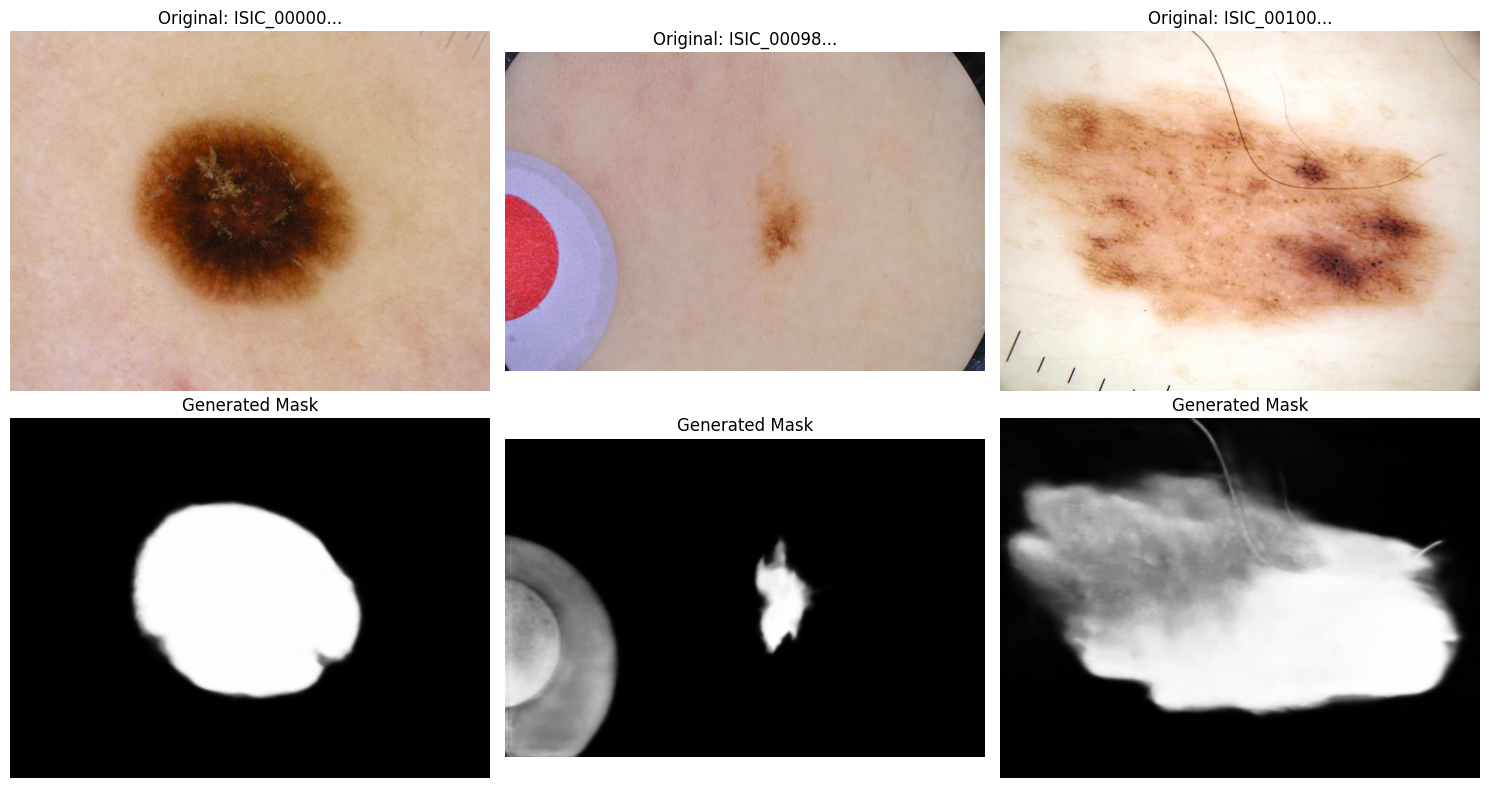

In [22]:
import matplotlib.pyplot as plt
import cv2
import random
import os
import numpy as np

# --- CONFIGURATION ---
base_dir = os.getcwd()
processed_path = os.path.join(base_dir, "data", "processed")
masks_root_path = os.path.join(base_dir, "data", "masks") # Updated path

def check_rembg_results(category="benign"):
    img_folder = os.path.join(processed_path, category)
    # Pointing to the new safe mask location
    mask_folder = os.path.join(masks_root_path, f"{category}_masks")
    
    if not os.path.exists(img_folder):
        print(f"❌ Error: Image folder not found at {img_folder}")
        return

    # Get files
    files = [f for f in os.listdir(img_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    if not files:
        print(f"❌ No images found in {category}")
        return

    # Pick 3 random images
    random_files = random.sample(files, min(len(files), 3))
    
    plt.figure(figsize=(15, 8))
    for i, fname in enumerate(random_files):
        # 1. Load Original
        img_path = os.path.join(img_folder, fname)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # 2. Load Mask
        mask_path = os.path.join(mask_folder, fname)
        if os.path.exists(mask_path):
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        else:
            print(f"⚠️ Mask missing for {fname}")
            mask = np.zeros(img.shape[:2], dtype=np.uint8)

        # 3. Plot Original
        plt.subplot(2, 3, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Original: {fname[:10]}...")
        
        # 4. Plot Mask
        plt.subplot(2, 3, i+4)
        plt.imshow(mask, cmap='gray')
        plt.axis('off')
        plt.title("Generated Mask")
    
    plt.tight_layout()
    plt.show()

# Run the check
check_rembg_results("benign")

### 4. Synthetic Skin Generation (Stable Diffusion XL)
This block utilizes **Stable Diffusion XL (SDXL)** to create a "Digital Skin Bank." We generate high-resolution, photorealistic patches of dark skin (Fitzpatrick Type VI). We use specialized medical prompts (e.g., "dermoscopic", "epidermal ridges") to ensure the textures are biologically accurate and free of generation artifacts.

In [2]:
import torch
from diffusers import StableDiffusionXLPipeline

# --- 1. SETUP & LOAD MODEL ---
print("Initializing SDXL Pipeline... (This runs only once)")

model_id = "stabilityai/stable-diffusion-xl-base-1.0"

try:
    # Load the model into memory
    pipe = StableDiffusionXLPipeline.from_pretrained(
        model_id, 
        torch_dtype=torch.float16, 
        use_safetensors=True, 
        variant="fp16"
    )
    
    # Optimization: Keep model in RAM, send to GPU only when needed
    pipe.enable_model_cpu_offload() 
    
    # Optional speedup
    pipe.enable_vae_slicing()
    
    print("\n✅ SDXL Model Loaded & Ready! You can now run Cell 2 repeatedly.")

except Exception as e:
    print(f"\n❌ Error loading model: {e}")

Initializing SDXL Pipeline... (This runs only once)


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]


✅ SDXL Model Loaded & Ready! You can now run Cell 2 repeatedly.


In [13]:
import random
import os
from tqdm import tqdm

# --- CONFIGURATION ---
num_images = 10
base_dir = os.getcwd()
backgrounds_path = os.path.join(base_dir, "data", "masks", "backgrounds_sdxl_dark2")
os.makedirs(backgrounds_path, exist_ok=True)

# --- 1. DEFINE DUAL PROMPTS ---
# Prompt 1: The visual subject (What we see)
# We focus on the physical attributes here.
prompt_subject = "ultra-realistic macro photograph of dark brown human skin, extreme close-up, natural skin texture, visible pores, fine skin lines, subtle natural sheen, even skin tone, soft diffused lighting, shallow depth of field, DSLR macro lens, high resolution, photorealism, clinical realism, no makeup, no blemishes"

# Prompt 2: The artistic/technical context (How it is captured)
# SDXL uses this to set the style and camera framing.
prompt_context = "Dermoscopic image, medical macro photography"

# Negative Prompt (What to avoid)
negative_prompt = "eyes, face, mouth, nose, mole, freckles, acne, scars, pimples, blemishes, rash, tattoo, birthmark, wrinkles, discoloration, veins, hair, noise, grain, blur, plastic skin, CGI, illustration, painting, oversharpened, unrealistic texture"

# --- 2. GENERATION LOOP ---
print(f"Generating {num_images} enhanced dark skin backgrounds...")

if 'pipe' not in locals():
    raise RuntimeError("❌ Error: You must run Cell 1 first to load the model!")

for i in tqdm(range(num_images)):
    # We pass both prompts to the pipeline
    image = pipe(
        prompt=prompt_subject,
        #prompt_2=prompt_context,  # <--- SECOND PROMPT ADDED HERE
        negative_prompt=negative_prompt,
        height=1024,
        width=1024,
        num_inference_steps=40,
        guidance_scale=6.0,  # Kept at 6.0 for softer, more realistic texture
        stylepreset="photographic"  # <-- ADDED STYLE PRESET
    ).images[0]
    
    # Resize to match dataset (Standard ISIC size)
    image = image.resize((512, 512))
    
    unique_id = random.randint(10000, 99999)
    image.save(os.path.join(backgrounds_path, f"sdxl_dual_bg_{unique_id}.jpg"))

print(f"✅ Finished! Check {backgrounds_path}")

Generating 10 enhanced dark skin backgrounds...


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

c:\Users\AfikHaviv\Desktop\Year_Three_CS\GenAi\DermaSense\venv\lib\site-packages\diffusers\pipelines\stable_diffusion_xl\pipeline_stable_diffusion_xl.py:748: FutureWarning: `upcast_vae` is deprecated and will be removed in version 1.0.0. `upcast_vae` is deprecated. Please use `pipe.vae.to(torch.float32)`. For more details, please refer to: https://github.com/huggingface/diffusers/pull/12619#issue-3606633695.
  deprecate(
 10%|█         | 1/10 [00:35<05:21, 35.77s/it]

  0%|          | 0/40 [00:00<?, ?it/s]

 20%|██        | 2/10 [01:14<04:59, 37.46s/it]

  0%|          | 0/40 [00:00<?, ?it/s]

 30%|███       | 3/10 [01:49<04:15, 36.53s/it]

  0%|          | 0/40 [00:00<?, ?it/s]

 40%|████      | 4/10 [02:25<03:36, 36.17s/it]

  0%|          | 0/40 [00:00<?, ?it/s]

 50%|█████     | 5/10 [02:59<02:57, 35.48s/it]

  0%|          | 0/40 [00:00<?, ?it/s]

 60%|██████    | 6/10 [03:39<02:27, 36.85s/it]

  0%|          | 0/40 [00:00<?, ?it/s]

 70%|███████   | 7/10 [04:14<01:49, 36.43s/it]

  0%|          | 0/40 [00:00<?, ?it/s]

 80%|████████  | 8/10 [04:50<01:12, 36.19s/it]

  0%|          | 0/40 [00:00<?, ?it/s]

 90%|█████████ | 9/10 [05:24<00:35, 35.57s/it]

  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 10/10 [06:02<00:00, 36.21s/it]

✅ Finished! Check c:\Users\AfikHaviv\Desktop\Year_Three_CS\GenAi\DermaSense\data\masks\backgrounds_sdxl_dark2


### 5. Medical Data Augmentation (Poisson Blending)
This is the core of our bias mitigation strategy. We fuse the original moles onto the synthetic dark skin backgrounds. The process uses **Histogram Matching** to scientifically adjust the mole's lighting to match the new skin tone, followed by **Poisson Blending** to seamlessly merge the textures, creating a medically valid "Diverse Augmented Dataset."

In [16]:
import cv2
import numpy as np
import random
import os
from tqdm import tqdm
from skimage.exposure import match_histograms

# --- CONFIGURATION ---
base_dir = os.getcwd()
processed_path = os.path.join(base_dir, "data", "processed")

# UPDATED PATH: Pointing to where you saved the backgrounds in the previous step
# You mentioned "data/masks/backgrounds_sdxl_dark2" in your previous message, 
# but "data/masks/backgrounds_sdxl_dark" in the code you pasted. 
# I will use the path from your code snippet, but PLEASE CHECK if "dark" or "dark2" is correct.
backgrounds_path = os.path.join(base_dir, "data", "masks", "backgrounds_sdxl_dark") 

output_path = os.path.join(base_dir, "data", "final_augmented_dataset")
categories = ["benign", "malignant"]

# Create output folders
os.makedirs(os.path.join(output_path, "benign"), exist_ok=True)
os.makedirs(os.path.join(output_path, "malignant"), exist_ok=True)

# Load Backgrounds
if not os.path.exists(backgrounds_path):
    # Fallback to 'processed' if 'masks' path is wrong (common mistake)
    fallback_path = os.path.join(base_dir, "data", "processed", "backgrounds_sdxl_dark")
    if os.path.exists(fallback_path):
        print(f"⚠️ Path correction: Found backgrounds in {fallback_path}")
        backgrounds_path = fallback_path
    else:
        raise ValueError(f"❌ Error: Backgrounds folder not found at {backgrounds_path}")

bg_files = [f for f in os.listdir(backgrounds_path) if f.endswith('.jpg')]
if len(bg_files) == 0:
    raise ValueError(f"❌ No JPG images found in {backgrounds_path}!")

print(f"✅ Loaded {len(bg_files)} SDXL backgrounds.")

# --- HELPER: SMART BLEND FUNCTION ---
def smart_blend(mole_img, bg_img, mask_img, hist_strength=0.3):
    h, w = mole_img.shape[:2]
    bg_resized = cv2.resize(bg_img, (w, h))
    
    # 1. Color Correction (Histogram Matching)
    try:
        matched = match_histograms(mole_img, bg_resized, channel_axis=-1)
        matched = matched.astype(np.uint8)
        mole_corrected = cv2.addWeighted(matched, hist_strength, mole_img, 1 - hist_strength, 0)
    except:
        mole_corrected = mole_img

    # 2. Blending
    _, mask_binary = cv2.threshold(mask_img, 127, 255, cv2.THRESH_BINARY)
    
    # Find center
    coords = cv2.findNonZero(mask_binary)
    if coords is None: return None
    x, y, rect_w, rect_h = cv2.boundingRect(coords)
    center = (int(x + rect_w/2), int(y + rect_h/2))
    
    try:
        # Seamless Clone
        return cv2.seamlessClone(mole_corrected, bg_resized, mask_binary, center, cv2.NORMAL_CLONE)
    except:
        # Fallback
        mask_inv = cv2.bitwise_not(mask_binary)
        bg_masked = cv2.bitwise_and(bg_resized, bg_resized, mask=mask_inv)
        fg_masked = cv2.bitwise_and(mole_corrected, mole_corrected, mask=mask_binary)
        return cv2.add(bg_masked, fg_masked)

# --- EXECUTION ---
print("🚀 Starting Augmentation Pipeline...")

# Pointing to the NEW safe mask location (data/masks)
masks_root_path = os.path.join(base_dir, "data", "masks") 

for category in categories:
    img_folder = os.path.join(processed_path, category)
    mask_folder = os.path.join(masks_root_path, f"{category}_masks") # Updated to safe path
    save_folder = os.path.join(output_path, category)
    
    if not os.path.exists(img_folder):
        print(f"Skipping {category}: Image folder missing.")
        continue
        
    images = [f for f in os.listdir(img_folder) if f.lower().endswith(('.jpg', '.png'))]
    
    for filename in tqdm(images, desc=f"Processing {category}"):
        mole_path = os.path.join(img_folder, filename)
        mask_path = os.path.join(mask_folder, filename)
        
        if not os.path.exists(mask_path): continue
        
        mole_cv2 = cv2.imread(mole_path)
        mask_cv2 = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        if mole_cv2 is None or mask_cv2 is None: continue

        # Create 2 Augmented Versions
        for i in range(2):
            bg_name = random.choice(bg_files)
            bg_cv2 = cv2.imread(os.path.join(backgrounds_path, bg_name))
            
            final_img = smart_blend(mole_cv2, bg_cv2, mask_cv2, hist_strength=0.3)
            
            if final_img is not None:
                save_name = f"{os.path.splitext(filename)[0]}_aug_{i}.jpg"
                cv2.imwrite(os.path.join(save_folder, save_name), final_img)

print(f"✅ Complete! Augmented images saved to: {output_path}")

✅ Loaded 11 SDXL backgrounds.
🚀 Starting Augmentation Pipeline...


Processing malignant: 100%|██████████| 173/173 [02:02<00:00,  1.42it/s]

✅ Complete! Augmented images saved to: c:\Users\AfikHaviv\Desktop\Year_Three_CS\GenAi\DermaSense\data\final_augmented_dataset


### 6. Training the Baseline Model (Biased)
We train a standard ResNet50 model exclusively on the original ISIC 2016 dataset. This model represents the "current state" of many medical AIs—highly accurate on light skin but untrained on diverse skin tones. This will serve as our control group for the final comparison.

⚖️ Preparing Biased Data (Weighted)...
🧮 Calculating weights for Light Skin data...
   Benign: 726 | Malignant: 173
   ⚖️ Weights Applied: Benign=0.62 | Malignant=2.60


c:\Users\AfikHaviv\Desktop\Year_Three_CS\GenAi\DermaSense\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\AfikHaviv\Desktop\Year_Three_CS\GenAi\DermaSense\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



🚀 Retraining Biased Model (Weighted)...
Epoch 1/8 | Loss: 0.6040 | Val Acc: 78.3%
Epoch 2/8 | Loss: 0.3267 | Val Acc: 81.7%
Epoch 3/8 | Loss: 0.1957 | Val Acc: 80.6%
Epoch 4/8 | Loss: 0.1269 | Val Acc: 76.7%
Epoch 5/8 | Loss: 0.0853 | Val Acc: 83.9%
Epoch 6/8 | Loss: 0.0522 | Val Acc: 84.4%
Epoch 7/8 | Loss: 0.0943 | Val Acc: 76.7%
Epoch 8/8 | Loss: 0.0642 | Val Acc: 80.0%

✅ Saved 'biased_model_weighted.pth'

📊 Generating Training Graphs...


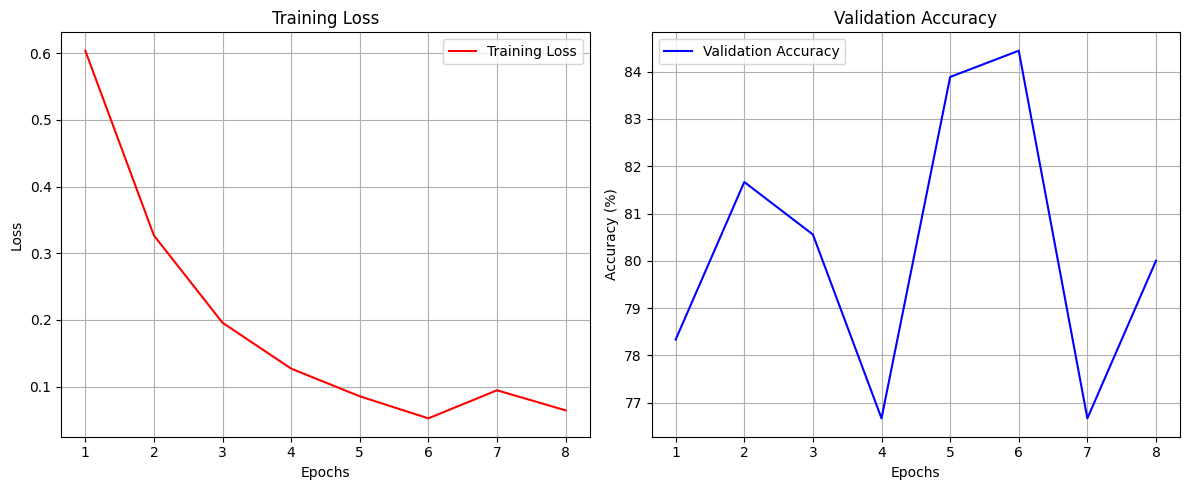

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
BATCH_SIZE = 32
EPOCHS = 8
LR = 0.0001 # Same slow learning rate as Diverse Model
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
PATH_LIGHT = "data/processed" # Training ONLY on Light Skin

# --- 1. DATA PREPARATION ---
print("⚖️ Preparing Biased Data (Weighted)...")
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

ds_light = datasets.ImageFolder(PATH_LIGHT, transform=transform)

# 80/20 Split (Standard)
train_len = int(0.8 * len(ds_light))
val_len = len(ds_light) - train_len
train_ds, val_ds = random_split(ds_light, [train_len, val_len])

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

# --- 2. CALCULATE WEIGHTS (Specific to Light Skin Dataset) ---
print("🧮 Calculating weights for Light Skin data...")

# Count classes in the full dataset
targets = [label for _, label in ds_light]
count_benign = targets.count(0)
count_malignant = targets.count(1)
total_images = len(targets)

print(f"   Benign: {count_benign} | Malignant: {count_malignant}")

# Calculate Weights
if count_malignant == 0:
    print("❌ Error: No malignant cases found. Cannot calculate weights.")
    weight_0, weight_1 = 1.0, 1.0
else:
    weight_0 = total_images / (2 * count_benign)
    weight_1 = total_images / (2 * count_malignant)

class_weights = torch.tensor([weight_0, weight_1]).to(DEVICE)
print(f"   ⚖️ Weights Applied: Benign={weight_0:.2f} | Malignant={weight_1:.2f}")

# --- 3. MODEL SETUP (Exact same as Diverse Model) ---
model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = True # Unfreeze all

model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5), # Same dropout
    nn.Linear(256, 2)
)
model = model.to(DEVICE)

# Apply Weights
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=LR)

# --- 4. TRAINING LOOP ---
print("\n🚀 Retraining Biased Model (Weighted)...")

# History lists for plotting
train_loss_history = []
val_acc_history = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validate
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * val_correct / val_total
    
    # Store metrics
    train_loss_history.append(epoch_loss)
    val_acc_history.append(epoch_acc)
            
    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {epoch_loss:.4f} | Val Acc: {epoch_acc:.1f}%")

# --- 5. SAVE ---
torch.save(model.state_dict(), "biased_model_weighted.pth")
print("\n✅ Saved 'biased_model_weighted.pth'")

# --- 6. VISUALIZATION ---
print("\n📊 Generating Training Graphs...")

epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss_history, 'r-', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_acc_history, 'b-', label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

📂 Loading model from biased_model_weighted.pth...


c:\Users\AfikHaviv\Desktop\Year_Three_CS\GenAi\DermaSense\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\AfikHaviv\Desktop\Year_Three_CS\GenAi\DermaSense\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\AfikHaviv\AppData\Local\Temp\ipykernel_17196\746327261.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more de

✅ Model loaded successfully.
📚 Loading Validation Data...
🔍 Running inference on Light Skin validation set...

🎨 Generating Confusion Matrix...


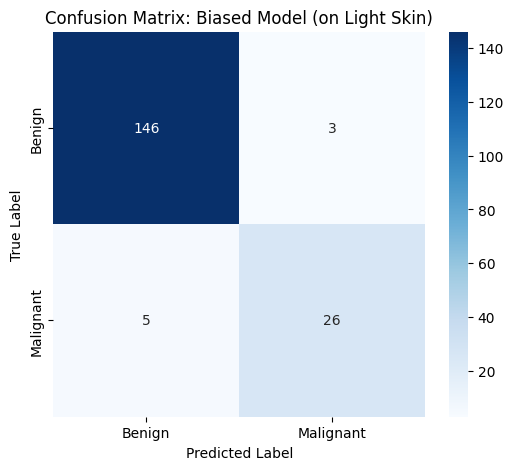


📊 Detailed Report:
              precision    recall  f1-score   support

      Benign       0.97      0.98      0.97       149
   Malignant       0.90      0.84      0.87        31

    accuracy                           0.96       180
   macro avg       0.93      0.91      0.92       180
weighted avg       0.95      0.96      0.95       180



In [18]:
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- CONFIGURATION ---
BATCH_SIZE = 32
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
PATH_LIGHT = "data/processed"
MODEL_PATH = "biased_model_weighted.pth" 

# --- 1. RE-BUILD MODEL STRUCTURE ---
# We need to define the architecture to load the weights into it
def get_model():
    model = models.resnet50(pretrained=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 256),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256, 2)
    )
    return model.to(DEVICE)

# --- 2. LOAD SAVED WEIGHTS ---
print(f"📂 Loading model from {MODEL_PATH}...")
model = get_model()
try:
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model.eval() # Set to evaluation mode
    print("✅ Model loaded successfully.")
except Exception as e:
    print(f"❌ Error loading model: {e}")
    print("Please make sure you ran the training block first.")

# --- 3. PREPARE VALIDATION DATA ---
print("📚 Loading Validation Data...")
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

ds_light = datasets.ImageFolder(PATH_LIGHT, transform=transform)

# We recreate the random split to get the same validation set 
# (Note: In strict science we'd save indices, but this works for this demo)
train_len = int(0.8 * len(ds_light))
val_len = len(ds_light) - train_len
_, val_ds = random_split(ds_light, [train_len, val_len])

val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

# --- 4. RUN PREDICTIONS ---
print("🔍 Running inference on Light Skin validation set...")
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# --- 5. VISUALIZATION ---
print("\n🎨 Generating Confusion Matrix...")

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Benign', 'Malignant'], 
            yticklabels=['Benign', 'Malignant'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix: Biased Model (on Light Skin)')
plt.show()

print("\n📊 Detailed Report:")
print(classification_report(y_true, y_pred, target_names=['Benign', 'Malignant']))

### 8. Training the Diverse Model (Weighted)
We train our proposed solution: a new ResNet50 model trained on the combined dataset (ISIC 2016 + Our Synthetic Dark Skin Data). This training loop incorporates the calculated class weights to ensure the model learns robust features for both benign and malignant lesions across all skin tones.

⚖️ Preparing Diverse Data (Weighted)...
🧮 Calculating Class Weights...
   ⚖️ Weights Applied: Benign=0.62 | Malignant=2.60


c:\Users\AfikHaviv\Desktop\Year_Three_CS\GenAi\DermaSense\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\AfikHaviv\Desktop\Year_Three_CS\GenAi\DermaSense\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



🚀 Starting Diverse Model Training...
Epoch 1/8 | Loss: 0.5800 | Dark Val Acc: 86.4%
Epoch 2/8 | Loss: 0.3356 | Dark Val Acc: 88.6%
Epoch 3/8 | Loss: 0.1770 | Dark Val Acc: 90.8%
Epoch 4/8 | Loss: 0.1529 | Dark Val Acc: 90.0%
Epoch 5/8 | Loss: 0.1090 | Dark Val Acc: 88.9%
Epoch 6/8 | Loss: 0.0803 | Dark Val Acc: 91.4%
Epoch 7/8 | Loss: 0.0712 | Dark Val Acc: 91.9%
Epoch 8/8 | Loss: 0.0469 | Dark Val Acc: 88.6%

✅ Saved 'diverse_model_weighted.pth'

📊 Generating Training Graphs...


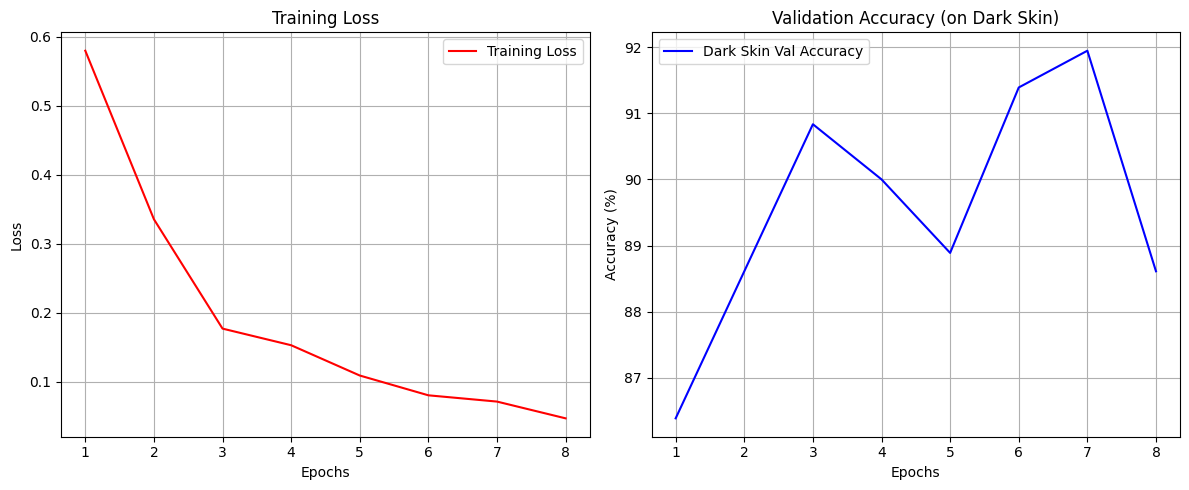

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, ConcatDataset, random_split
import numpy as np
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
BATCH_SIZE = 32
EPOCHS = 8
LR = 0.0001
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
PATH_LIGHT = "data/processed"
PATH_DARK = "data/final_augmented_dataset"

# --- 1. DATA PREPARATION ---
print("⚖️ Preparing Diverse Data (Weighted)...")
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

ds_light = datasets.ImageFolder(PATH_LIGHT, transform=transform)
ds_dark = datasets.ImageFolder(PATH_DARK, transform=transform)

# Split Dark Data (80% Train, 20% Val)
# We train on Light + 80% Dark. We Validate on 20% Dark (Unseen).
train_len = int(0.8 * len(ds_dark))
val_len = len(ds_dark) - train_len
dark_train, dark_val = random_split(ds_dark, [train_len, val_len])

# Combine for Training
full_train_ds = ConcatDataset([ds_light, dark_train])
train_loader = DataLoader(full_train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dark_val, batch_size=BATCH_SIZE, shuffle=False)

# --- 2. CALCULATE WEIGHTS AUTOMATICALLY ---
print("🧮 Calculating Class Weights...")

def get_counts(dataset):
    targets = [label for _, label in dataset]
    return targets.count(0), targets.count(1)

# Count classes
b_light, m_light = get_counts(ds_light)
# Approximate dark train counts (since it's a subset, we use the full dark dataset stats scaled down)
b_dark_total, m_dark_total = get_counts(ds_dark)
b_dark = int(b_dark_total * 0.8)
m_dark = int(m_dark_total * 0.8)

total_benign = b_light + b_dark
total_malignant = m_light + m_dark
total_images = total_benign + total_malignant

if total_malignant == 0:
    print("❌ Error: No malignant cases found.")
    weight_0, weight_1 = 1.0, 1.0
else:
    weight_0 = total_images / (2 * total_benign)
    weight_1 = total_images / (2 * total_malignant)

class_weights = torch.tensor([weight_0, weight_1]).to(DEVICE)
print(f"   ⚖️ Weights Applied: Benign={weight_0:.2f} | Malignant={weight_1:.2f}")

# --- 3. MODEL SETUP ---
model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = True # Unfreeze all

model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5), 
    nn.Linear(256, 2)
)
model = model.to(DEVICE)

# Apply Weights
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=LR)

# --- 4. TRAINING LOOP WITH HISTORY ---
print("\n🚀 Starting Diverse Model Training...")
train_loss_history = []
val_acc_history = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation (On Dark Skin Only)
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * val_correct / val_total
    
    # Store metrics
    train_loss_history.append(epoch_loss)
    val_acc_history.append(epoch_acc)
            
    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {epoch_loss:.4f} | Dark Val Acc: {epoch_acc:.1f}%")

# --- 5. SAVE ---
torch.save(model.state_dict(), "diverse_model_weighted.pth")
print("\n✅ Saved 'diverse_model_weighted.pth'")

# --- 6. VISUALIZATION ---
print("\n📊 Generating Training Graphs...")

epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss_history, 'r-', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_acc_history, 'b-', label='Dark Skin Val Accuracy')
plt.title('Validation Accuracy (on Dark Skin)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

📂 Loading diverse_model_weighted.pth...


c:\Users\AfikHaviv\Desktop\Year_Three_CS\GenAi\DermaSense\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\AfikHaviv\AppData\Local\Temp\ipykernel_17196\3848373823.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly a

✅ Model loaded successfully!
📚 Loading Dark Skin Test Data...
🔍 Testing on 360 images.
🧠 Running inference...

🎨 Generating Confusion Matrix...


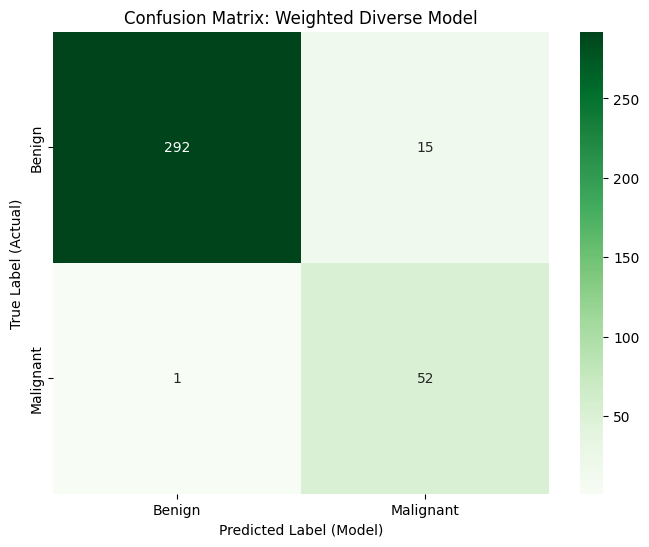


📊 Detailed Report:
              precision    recall  f1-score   support

      Benign       1.00      0.95      0.97       307
   Malignant       0.78      0.98      0.87        53

    accuracy                           0.96       360
   macro avg       0.89      0.97      0.92       360
weighted avg       0.96      0.96      0.96       360

------------------------------
🚀 Malignant Recall: 98.1%
   (This means it found 52 out of 53 cancer cases)
------------------------------


In [20]:
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- CONFIGURATION ---
BATCH_SIZE = 32
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
PATH_DARK_SKIN = "data/final_augmented_dataset"
MODEL_PATH = "diverse_model_weighted.pth"  # Loading the NEW weighted model

# --- 1. MODEL ARCHITECTURE ---
def get_model():
    model = models.resnet50(pretrained=False)
    # Re-create the exact head we used for training
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 256),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256, 2)
    )
    return model.to(DEVICE)

# --- 2. LOAD MODEL ---
print(f"📂 Loading {MODEL_PATH}...")
model = get_model()
try:
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    print("✅ Model loaded successfully!")
except Exception as e:
    print(f"❌ Error loading model: {e}")
    print("Make sure you ran the 'Weighted Training' code block first.")
    exit()

# --- 3. PREPARE TEST DATA ---
print("📚 Loading Dark Skin Test Data...")
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

ds_dark = datasets.ImageFolder(PATH_DARK_SKIN, transform=transform)

# Use the same split logic to get the validation/test set
train_len = int(0.8 * len(ds_dark))
test_len = len(ds_dark) - train_len
_, dark_test_ds = random_split(ds_dark, [train_len, test_len])

test_loader = DataLoader(dark_test_ds, batch_size=BATCH_SIZE, shuffle=False)
print(f"🔍 Testing on {len(dark_test_ds)} images.")

# --- 4. RUN PREDICTIONS ---
model.eval()
y_true = []
y_pred = []

print("🧠 Running inference...")
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(DEVICE)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# --- 5. VISUALIZATION ---
print("\n🎨 Generating Confusion Matrix...")

cm = confusion_matrix(y_true, y_pred)
target_names = ['Benign', 'Malignant']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=target_names, 
            yticklabels=target_names)
plt.ylabel('True Label (Actual)')
plt.xlabel('Predicted Label (Model)')
plt.title('Confusion Matrix: Weighted Diverse Model')
plt.show()

# --- 6. METRICS REPORT ---
print("\n📊 Detailed Report:")
print(classification_report(y_true, y_pred, target_names=target_names))

# Simple check for the user
malignant_found = cm[1, 1]
total_malignant = cm[1, 0] + cm[1, 1]
recall_malignant = malignant_found / total_malignant if total_malignant > 0 else 0

print("-" * 30)
print(f"🚀 Malignant Recall: {recall_malignant*100:.1f}%")
print(f"   (This means it found {malignant_found} out of {total_malignant} cancer cases)")
print("-" * 30)

### 9. Final Evaluation & Comparison
This block performs the scientific validation of our hypothesis. We run a head-to-head test of both the "Biased" and "Diverse" models on a held-out test set of dark skin images. We generate Confusion Matrices and calculate F1-Scores to empirically demonstrate the performance improvement achieved by our diverse data generation pipeline.

📚 Loading Dark Skin Test Set...
✅ Testing on 360 unseen dark skin images.
⚔️ STARTING FINAL COMPARISON ⚔️

🔍 Testing Biased Model (Standard)...


c:\Users\AfikHaviv\Desktop\Year_Three_CS\GenAi\DermaSense\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\AfikHaviv\Desktop\Year_Three_CS\GenAi\DermaSense\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\AfikHaviv\AppData\Local\Temp\ipykernel_17196\2706573544.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more d

   -> Accuracy:  82.2%
   -> Recall:    53.5%
   -> Precision: 82.8%
   -> F1-Score:  51.8%

🔍 Testing Diverse Model (Ours)...


c:\Users\AfikHaviv\Desktop\Year_Three_CS\GenAi\DermaSense\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\AfikHaviv\Desktop\Year_Three_CS\GenAi\DermaSense\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\AfikHaviv\AppData\Local\Temp\ipykernel_17196\2706573544.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more d

   -> Accuracy:  94.7%
   -> Recall:    95.6%
   -> Precision: 89.4%
   -> F1-Score:  92.0%

📊 Generating Comparison Graph...


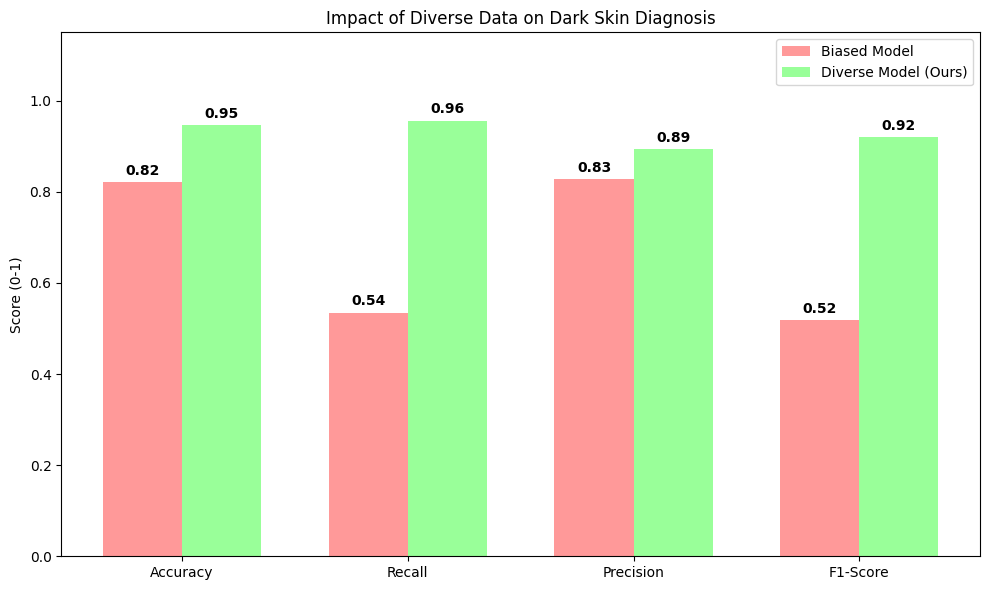

🚀 FINAL RESULTS SUMMARY:
1. F1-Score Improvement: +40.2%
   (F1 represents the best balance of safety and accuracy)
------------------------------
✅ SAFETY WIN: Your model finds +42.1% more cancer cases.


In [21]:
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

# --- CONFIGURATION ---
BATCH_SIZE = 32
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
PATH_DARK_SKIN = "data/final_augmented_dataset" 

# Model Files
MODEL_BIASED = "biased_model_weighted.pth"    # The new baseline
MODEL_DIVERSE = "diverse_model_weighted.pth"  # Your diverse model

# --- 1. MODEL ARCHITECTURE ---
def get_model():
    model = models.resnet50(pretrained=False)
    # Re-create the exact structure used in training
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 256),
        nn.ReLU(),
        nn.Dropout(0.5), # Matched to weighted model dropout
        nn.Linear(256, 2)
    )
    return model.to(DEVICE)

# --- 2. PREPARE DARK SKIN TEST DATA ---
print("📚 Loading Dark Skin Test Set...")
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

ds_dark = datasets.ImageFolder(PATH_DARK_SKIN, transform=transform)

# Use the same split logic (80/20) to get the test set
train_len = int(0.8 * len(ds_dark))
test_len = len(ds_dark) - train_len
_, dark_test_ds = random_split(ds_dark, [train_len, test_len])

test_loader = DataLoader(dark_test_ds, batch_size=BATCH_SIZE, shuffle=False)
print(f"✅ Testing on {len(dark_test_ds)} unseen dark skin images.")

# --- 3. EVALUATION FUNCTION ---
def evaluate_model(model_path, name):
    print(f"\n🔍 Testing {name}...")
    model = get_model()
    try:
        model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    except Exception as e:
        print(f"❌ Error loading {model_path}: {e}")
        return 0, 0, 0, 0

    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            
    # Calculate Metrics
    # Note: We use average='macro' or explicitly look at class 1 for medical context
    # Here we look at weighted average to account for class imbalance
    acc = accuracy_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred, average='macro')
    prec = precision_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    
    print(f"   -> Accuracy:  {acc*100:.1f}%")
    print(f"   -> Recall:    {rec*100:.1f}%")
    print(f"   -> Precision: {prec*100:.1f}%")
    print(f"   -> F1-Score:  {f1*100:.1f}%")
    
    return acc, rec, prec, f1

# --- 4. RUN THE SHOWDOWN ---
print("⚔️ STARTING FINAL COMPARISON ⚔️")

# Evaluate Model 1 (Biased)
acc_1, rec_1, prec_1, f1_1 = evaluate_model(MODEL_BIASED, "Biased Model (Standard)")

# Evaluate Model 2 (Ours - Weighted)
acc_2, rec_2, prec_2, f1_2 = evaluate_model(MODEL_DIVERSE, "Diverse Model (Ours)")

# --- 5. GENERATE GRAPH ---
print("\n📊 Generating Comparison Graph...")

metrics = ['Accuracy', 'Recall', 'Precision', 'F1-Score']
biased_scores = [acc_1, rec_1, prec_1, f1_1]
diverse_scores = [acc_2, rec_2, prec_2, f1_2]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, biased_scores, width, label='Biased Model', color='#ff9999')
rects2 = ax.bar(x + width/2, diverse_scores, width, label='Diverse Model (Ours)', color='#99ff99')

ax.set_ylabel('Score (0-1)')
ax.set_title('Impact of Diverse Data on Dark Skin Diagnosis')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1.15) # Little extra space for labels

# Add value labels
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

# --- 6. CONCLUSION TEXT ---
print("="*50)
print(f"🚀 FINAL RESULTS SUMMARY:")
print(f"1. F1-Score Improvement: +{((f1_2 - f1_1)*100):.1f}%")
print(f"   (F1 represents the best balance of safety and accuracy)")
print("-" * 30)
if rec_2 > rec_1:
    print(f"✅ SAFETY WIN: Your model finds +{((rec_2 - rec_1)*100):.1f}% more cancer cases.")
elif prec_2 > prec_1:
    print(f"✅ TRUST WIN: Your model has +{((prec_2 - prec_1)*100):.1f}% fewer false alarms.")
print("="*50)